# Задание 2

При решении данного задания я пробовал использовать библиотеку sklearn для возможности "машинного обучения" компьютера посредством множества примеров, на которых он сможет натренироваться и правильно определять форму того или иного стихотворения. Однако подобный способ, во-первых, является очень долгим для реализации, поскольку требует большого числа произведений, которые будут выступать в роли "учителя" для компьютера, а во-вторых, такой метод обучения очень долго обрабатывается самой машиной, так как в этом случае компьютер обрабатывает очень большие объемы информации. В этой связи я решил написать принцип определения формы стихотворения вручную. По первым трем строчкам компьютер, исходя из ударений в каждом слове, смотрит, на какой из классов больше всего похоже произведение. Подробное описание данного метода будет приведено позже, в комментариях к коду. Файл, в котором хранятся все стихотворения А.С.Пушкин был взят из интернета в формату fb2, чтобы не повредить его содержание. Сам файл приложен в письме.

### Часть 1. Импорт всех требуемых библиотек.

In [1]:
# Для чтения html-страниц
from bs4 import BeautifulSoup as bs 

# Для определения языка стихотворений
from langdetect import detect

# Для отправки запросов в сеть
import requests as rq

# Для работы со знаками препинания
import string

# Для работы с numpy-массивами
import numpy as np

# Для построения графика
import matplotlib.pyplot as plt

# Для преобразования данных при построении графика
import pandas as pd

### Часть 2. Работа с файлом: извлечение каждого стихотворения с названием и годом, приведение всех данных к требуемому виду (preprocessing data).

In [2]:
# Создаем класс "стихотворение", в котором будет приведено название, текст, год, стихотворный размер, а также
# специальный код для поиска произведения в импортируемом файле.
class Poem:
    def __init__(self, title, year, poem='', nickname='', form=''):
        self.title = title
        self.poem = poem
        self.year = year
        self.nickname = nickname
        self.form = form

# Создаем два пустых списка. В первый впоследствии будем добавлять классы "стихотворение",
# а второй нужен для поиска нужного произведения в файле.
poems = []
dirts = []

# Открываем импортируемый файл, читаем его с помощью библиотеки beautiful soup.
with open('Pushkin.fb2', 'r', encoding='utf8') as file:
    body = bs(file, "html.parser")
    
    # Все названия добавляем в специальный список в необработанном виде.
    bad_titles = list(body.find_all('title'))
    
    # Этот список будет хранить названия в виде "<title><p>Название</p>\n</title>".
    dirty_titles = [bs(str(i), "html.parser").title for i in bad_titles]
    
    # Приводим элементы списка названий к нужному виду.
    titles = [str(bs(str(i), "html.parser").title.p.string) for i in bad_titles]
    
    # Рассмотрим названия, с которыми что-то пошло не так. Ошибки произошли в связи с тем, что некоторые названия содержат
    # дополнительную информацию после них внутри '<p>', поэтому для их корректного извелчения сначала отбрасываем '<p>'
    # из строки, а все идущее до следующего знака '<', характеризующего либо блок с лишней информацией
    # (например, нвазвание стихотворения "Анчар" выглядит следующиим образом:
    # '<p>Анчар.<a l:href="#n_51" type="note">[51]</a></p>'), кроме предшествующей ему точки (в данных исключениях 
    # она всегда идет после названия, кроме стихотворения 'Из Barry Cornwall', в котором можно пожертвовать последней
    # буквой 'l' ради общего блага),  отправляем в название. Ищем '<', начиная с первого элемента строки, потому что
    # знак '<' входит сначала нулевым элементом.
    for i in range(len(titles)):
        if titles[i] == 'None':
            del titles[i]
            my_title = str(bs(str(bad_titles[i]), "html.parser").title.p)
            titles.insert(i, my_title[3:my_title.find('<', 1)-1])
    
    # Элементы из списка названий не все являются названиями.
    # Начиная с "Примечаний" попавшие в данную категорию объекты - не названия стихотворений. Избавимся от них.
    end = titles.index('Примечания')
    
    # Первый элемент тоже не является названием.
    titles = titles[1:end]
    
    # Обрежем также список с названиями в виде "<title><p>Название</p>\n</title>".
    dirty_titles = dirty_titles[1:len(titles)+1]
    
    # Применим метод перевода в строку к каждому элементу списка с названиями.
    titles = list(map(str, titles))
    
    # Для каждого названия проделаем следующую операцию:
        #1. Смотрим, фигурирует ли в названии число 18. Как известно, стихотворений с подобным заголовком у А.С.Пушкина не было.
            # Соответственно, этот объект "title" означает год, соответствующий последующим произведениям. Поэтому "извлечем"
            # из названия сам год нехитрыми преобразованиями, и пока не встретим следующий подобный объект (характеризующий год),
            # всем объектам будем присуждать данный год.
        #2. Если число 18 не присутствует в названии, тогда можно смело заявлять, что это название стихотворения и добавлять в 
            # ранее приготовленный список poems объект класса Poem, с данным названием и годом, полученным в результате 
            # приведенных выше преобразований.
    for one in titles:
        if '18' in one:
            cathegory = int(one[one.index('18'):one.index('18') + 4])
        else:
            poems.append(Poem(one, cathegory))
            
    # Похожую операцию проделаем для списка с "грязными" названиями, только в данном случае в конечный список пойдут только 
    # сами назавания произведений. Получим список, как в предыдущем пункте, в котором названия будут в необработанном виде.
    for one in dirty_titles:
        if '18' not in str(one):
            dirts.append(one)
            
    # Каждому элементу списка poems присудим соответствующее необработанное название.
    for i in range(len(poems)):
        poems[i].nickname = dirts[i]
        
    # Время использовать "грязные" названия. Ищем, где данный код встречается в тексте в первый раз и обрезаем текст,
    # начиная с этого момента, а первый идущий объект '<poem>' проверяем на русскоязычность и, если тест на русский язык пройден, 
    # присуждаем классу с данным названием, а если стихотворение на французском, то относим к названию следующий объект '<poem>'
    # (это будет перевод на русский). Во-первых, это поможет избежать непредвиденных ошибок, когда, например, название состоит 
    # из одного слова ("Желание", Истина" и тд), а название, включающее в себя данное слово ("Желание славы") стоит ранее,
    # вследствие чего компьютер определил бы данному объекту Poem неправильный текст. Во-вторых, даный метод с каждым
    # шагом уменьшает размер файла (ix), находящегося в активной памяти, что существенно повышает время работы. 
    for j in poems:
        ix = str(body).split(str(j.nickname))
        the_poem = bs(ix[1], "html.parser").poem.text
        if detect(the_poem) != 'ru':
            ix = str(ix[1]).split('</poem>')
            the_poem = bs(ix[1], "html.parser").poem.text
        j.poem = the_poem    

### Часть 3. Определение формы каждого стихотворения.

In [3]:
# Будем определять принадлежность стихотворения тому или иному классу по первым трем (3) строчкам - это позволит, во-первых,
# достаточно уверенно определять форму стиха, а во-вторых, не будет перегружать оперативную память.
q = range(3)

# Создаем правило, по которому будем удалять знаки препинания из текста (при помощи данного механизма они удаляются все до единого).
rule = dict((ord(char), None) for char in string.punctuation) 

# Создаем список со всеми возможными ударными гласными в русском языке.
stressed = ['А', 'Е', 'И', 'Ё', 'У', 'О', 'Ю', 'Я',  'Э', 'Ы']

# Аналогично с безударными.
unstressed = [i.lower() for i in stressed]

# Для каждого объекта класса "Poem" в списке poems (хранящем все объекты этого класса):
for one in poems: 
    
    # Каждый раз будем реинициализировать списки со словами строки i (lines), ударениями (accents) и гласными в них 
    # (vowels), а число задействованных строчек возвращать к нулю (так как в данном стихотворении пока что не была задействована
    # ни одна.) Список слов четвертой строки (четвертый список в lines) добавлен для того, чтобы после деления
    # "склеивающихся" слов программа не выдавала ошибку об отсутствии соответствующего элемента в списке lines. 
    # Предназначение переменных length, is_horej и is_yamb будет объяснено позже.
    n_line = 0
    lines = [[], [], [], []]
    vowels = [[], [], []]
    accents = [[], [], []]
    (length, is_horej, is_yamb) = (0, 0, 0)
    
    # Для каждого слова в тексте:
    for i in map(lambda x: x.translate(rule), one.poem.split(' ')):
        
        # Если слово не стоит на стыке строк, когда два слова "склеиваются", то оно должно быть равно себе самому,
        # переведенному в нижний регистр, начиная со второй буквы: первая будет заглавной если слово первое в тексте,
        # если данное слово - имя собственное, если слово выделено автором с большой буквы ("из Ада") и т. д.
        # Все соотвествующие такому критерию слова добавляем в список слов данной строки. В случае, когда слово стоит
        # на стыке строк, последнее слово предшествующей и первое новой строки склеются, вследствие чего где-то в середине
        # "двойного" слова образуется заглавная буква - первая буква первого слова новой строки, и слово придется делить.
        if (i[1:] == i.lower()[1:]):
            lines[n_line].append(i.translate(rule).lower())
            
        # Если слово на стыке строк, путем нехитрых преобразований делим его на два имеющихся слова, после чего
        # добавляем первое в список слов старой строки, а новое - в список слов новой (прибавив 1 к переменной
        # номера строки).
        else:
            i = i.translate(rule)
            i = i[0].lower() + str(i[1:])
            separator = np.array(list(i))[np.array(list(i)) != np.array(list(i.lower()))][0]
            t = i.split(separator)
            lines[n_line].append(t[0])
            n_line += 1
            lines[n_line].append(str(separator).lower() + t[1])
        
        # Если слова из первых трех строк уже добавлены в соответствующий список, заканчиваем импорт слов.
        if n_line == 3:
            break
    
    # Более четвертая строка нас не интересует, можем смело ее удалять.
    lines = lines[:-1]
    
    # Для каждого слова каждой строки посылаем запрос на сайт ударений и "извлекаем" его ударение. Переменная n играет роль числа,
    # лежащего в пределах от 0 до rows-1, где rows - число строк, по которым мы проверяем форму стихотворения.
    for n in q:
        for word in lines[n]:
            page = rq.get("https://где-ударение.рф/в-слове-{0}/".format(word.lower())).text
        
            # Если запрос прошел и слово существует в словаре ударений (например, там отсутствуют односложные слова),
            # посредством beautiful soup получаем ударение в данном слове. Подобный метод, безусловно, не является идеальным - 
            # например, бывают слова, в которых ударение может ставиться на разные гласные в зависимости от его смысла:
            # Стрáстное - страстнóе, áтлас - атлáс и т. д. - в этом случае будет использован первый приведенный на сайте
            # вариант ударения. Однако такой способ позволяет проверить удрение практически в каждом слове вне зависимости от его
            # формы, склонения/спряжения и т.п.
            if bs(page, "html.parser").find(class_="rule") != None:
                accents[n].append(str(bs(page, "html.parser").find(
                    class_="rule").text).strip().split(' ')[-1].translate(rule))
        
            # Эмпирическим путем для бóльшей части стихотворений А.С.Пушкина было получено, что отсутствуют в словаре лишь
            # односложные слова. Соответственно, у такого слова ударным будет его единственный гласный звук - поэтому переводим все
            # слово в верхний регистр, чтобы затем в соответствующий список добавить его гласную как ударную. Бесспорно, зачастую
            # в стихотворениях односложные слова являются безударными ("Мой дЯдя самых четсных правил" - слово "мой" - безударное).
            # Тем не менее, на метод определения формы стихотворения данные неточности не будут оказывать почти никакого влияния,
            # потому что вероятность того, что если мы, допустим, имеем дело с ямбом, то есть ударные - все четные слоги, а 
            # на все или практически все нечетные слоги выпадают односложные слова, ничтожно мала. Иными словами, решение о 
            # классификации текста будет приниматься в зависимости от числа безударных гласных соответствующей кратности,
            # поэтому лишние ударные другой кратности не будут добавлять шумового эффекта.
            else:
                accents[n].append(word.upper())
                
        # Теперь для каждой буквы слов в accents проверяем, является ли она гласной (то есть формирует она слог или нет),
        # и в случае положительного ответа добавляем его в список гласных.
        for one_word in accents[n]:
            for letter in one_word:
                if letter in unstressed+stressed:
                     vowels[n].append(letter)
    
    # Для списка гласных каждой строки проделаем следующую операцию:
    for n in q:
        
        # В список res добавляем номера всех ударных гласных. Если стихотворение имеет форму хорея, все нечетные гласные,
        # возможно, за исключением одной-двух (делая поправку на возможные неточности) будут ударными, если форму ямба - 
        # то почти все или все четные гласные. Величина возможной ошибки будет следующей: смотрим общее число гласных/слогов
        # в использующихся строках - в нашем случае в трех строках - переменная length. Это число нацело делим на 5,
        # получая допустимое число ошибок - то есть примерно на каждые 5 слогов мы допускаем одну погрешность.
        res = [j for j in range(len(vowels[n])) if (vowels[n][j] in stressed)]
        
        # Добавляем число слогов данной строки к общему числу слогов в используемых строках.
        length += len(vowels[n])
        horej = np.arange(len(vowels[n]), step=2)
        yamb = np.arange(1, len(vowels[n]), step=2)
        
        # Добавляем количество гласных, которые должны бы были быть ударными при соответствующей форме стихотворения,
        # но ими не являются, в переменные is_horej и is_yamb. Если значение какой-то переменной превысит значение 
        # length // 5 - то число ошибок превысит допустимую норму и, следовательно, данная форма отвергается.
        is_horej += len([a for a in horej if (a not in res)])
        is_yamb += len([a for a in yamb if (a not in res)])
        
       
    # Завершающая стадия - сравниваем значения переменных is_horej и is_yamb с length // 5. Так как известно, что бóльшая 
    # часть стихотворений Александра Сергеевича была написана в форме ямба, то если вдруг возникнет ситуация, когда по "ударности"
    # гласных стихотворение можно будет отнести как к ямбу, так и к хорею, а число "ошибок" (величины переменных is_yamb
    # и is_horej) одинаковое, то отнесем его к ямбу.
    if is_yamb <= is_horej:
        if is_yamb <= length // 5:
            one.form = 'Ямб'
        else:
            one.form = 'Прочее'
    else:
        if is_horej <= length // 5:
            one.form = 'Хорей'
        else:
            one.form = 'Прочее'
            
    print('Закончен анализ стихотворения {0}. Оно имеет форму {1}.'.format(one.title, one.form))

Закончен анализ стихотворения К Наталье. Оно имеет форму Хорей.
Закончен анализ стихотворения Монах. Оно имеет форму Ямб.
Закончен анализ стихотворения Песнь первая. Оно имеет форму Ямб.
Закончен анализ стихотворения Песнь вторая. Оно имеет форму Ямб.
Закончен анализ стихотворения Песнь третия. Оно имеет форму Ямб.
Закончен анализ стихотворения Несчастие клита. Оно имеет форму Ямб.
Закончен анализ стихотворения К другу стихотворцу. Оно имеет форму Ямб.
Закончен анализ стихотворения Кольна. Оно имеет форму Ямб.
Закончен анализ стихотворения Эвлега. Оно имеет форму Ямб.
Закончен анализ стихотворения Осгар. Оно имеет форму Ямб.
Закончен анализ стихотворения Рассудок и любовь. Оно имеет форму Ямб.
Закончен анализ стихотворения К сестре. Оно имеет форму Ямб.
Закончен анализ стихотворения Красавице, которая нюхала табак. Оно имеет форму Ямб.
Закончен анализ стихотворения Эпиграмма. Оно имеет форму Ямб.
Закончен анализ стихотворения Козак. Оно имеет форму Хорей.
Закончен анализ стихотворения 

Закончен анализ стихотворения Тургеневу. Оно имеет форму Ямб.
Закончен анализ стихотворения К ***. Оно имеет форму Ямб.
Закончен анализ стихотворения К ней. Оно имеет форму Ямб.
Закончен анализ стихотворения Вольность. Ода. Оно имеет форму Ямб.
Закончен анализ стихотворения Кривцову. Оно имеет форму Хорей.
Закончен анализ стихотворения Лицинию. Оно имеет форму Ямб.
Закончен анализ стихотворения Старик. Оно имеет форму Ямб.
Закончен анализ стихотворения Роза. Оно имеет форму Ямб.
Закончен анализ стихотворения Гроб Анакреона. Оно имеет форму Хорей.
Закончен анализ стихотворения Певец. Оно имеет форму Ямб.
Закончен анализ стихотворения К Морфею. Оно имеет форму Ямб.
Закончен анализ стихотворения Друзьям. Оно имеет форму Ямб.
Закончен анализ стихотворения Амур и Гименей. Оно имеет форму Ямб.
Закончен анализ стихотворения Шишкову. Оно имеет форму Ямб.
Закончен анализ стихотворения Пробуждение. Оно имеет форму Ямб.
Закончен анализ стихотворения Любопытный. Оно имеет форму Ямб.
Закончен анали

Закончен анализ стихотворения Аделе. Оно имеет форму Ямб.
Закончен анализ стихотворения Узник. Оно имеет форму Прочее.
Закончен анализ стихотворения <Из письма к В. П. Горчакову.>. Оно имеет форму Ямб.
Закончен анализ стихотворения Птичка. Оно имеет форму Ямб.
Закончен анализ стихотворения <Л. Пушкину>. Оно имеет форму Ямб.
Закончен анализ стихотворения [Чиновник и поэт.]. Оно имеет форму Ямб.
Закончен анализ стихотворения <М. Е. Эйхфельдт.>. Оно имеет форму Ямб.
Закончен анализ стихотворения Царское село. Оно имеет форму Ямб.
Закончен анализ стихотворения Жалоба. Оно имеет форму Ямб.
Закончен анализ стихотворения Ночь. Оно имеет форму Ямб.
Закончен анализ стихотворения <Из письма к Вигелю.>. Оно имеет форму Ямб.
Закончен анализ стихотворения Демон. Оно имеет форму Ямб.
Закончен анализ стихотворения «Свободы сеятель пустынный…». Оно имеет форму Ямб.
Закончен анализ стихотворения Кн. М. А. Голицыной. Оно имеет форму Ямб.
Закончен анализ стихотворения Телега жизни. Оно имеет форму Ямб.
З

Закончен анализ стихотворения «Дар напрасный, дар случайный…». Оно имеет форму Хорей.
Закончен анализ стихотворения И. В. Сленину. Оно имеет форму Ямб.
Закончен анализ стихотворения Ее глаза. Оно имеет форму Ямб.
Закончен анализ стихотворения К Языкову. Оно имеет форму Ямб.
Закончен анализ стихотворения <Н. Д. Киселеву.>. Оно имеет форму Ямб.
Закончен анализ стихотворения Портрет. Оно имеет форму Ямб.
Закончен анализ стихотворения Наперсник. Оно имеет форму Ямб.
Закончен анализ стихотворения Кирджали. Оно имеет форму Ямб.
Закончен анализ стихотворения Предчувствие. Оно имеет форму Хорей.
Закончен анализ стихотворения Утопленник. Оно имеет форму Хорей.
Закончен анализ стихотворения <Б. М. Федорову.>. Оно имеет форму Ямб.
Закончен анализ стихотворения <Из альбома А. П. Керн.>. Оно имеет форму Хорей.
Закончен анализ стихотворения Клеопатра. Оно имеет форму Ямб.
Закончен анализ стихотворения Анчар. Оно имеет форму Ямб.
Закончен анализ стихотворения Ответ Катенину. Оно имеет форму Ямб.
Зако

Закончен анализ стихотворения (Из Анакреона). Оно имеет форму Хорей.
Закончен анализ стихотворения Ода LVI. Оно имеет форму Хорей.
Закончен анализ стихотворения Ода LVII. Оно имеет форму Хорей.
Закончен анализ стихотворения Полководец. Оно имеет форму Ямб.
Закончен анализ стихотворения Туча. Оно имеет форму Прочее.
Закончен анализ стихотворения Из А. Шенье. Оно имеет форму Ямб.
Закончен анализ стихотворения «На Испанию родную…». Оно имеет форму Хорей.
Закончен анализ стихотворения <Ha Дондукова-Корсакова.). Оно имеет форму Прочее.
Закончен анализ стихотворения Странник. Оно имеет форму Ямб.
Закончен анализ стихотворения <Плетневу.>. Оно имеет форму Ямб.
Закончен анализ стихотворения На выздоровление Лукулла. Подражание Латинскому. Оно имеет форму Ямб.
Закончен анализ стихотворения Пир Петра Первого. Оно имеет форму Хорей.
Закончен анализ стихотворения Подражание Арабскому. Оно имеет форму Хорей.
Закончен анализ стихотворения Д. В. Давыдову. Оно имеет форму Ямб.
Закончен анализ стихотво

### Часть 4. Построение графика с количеством стихотворений каждой формы по годам.

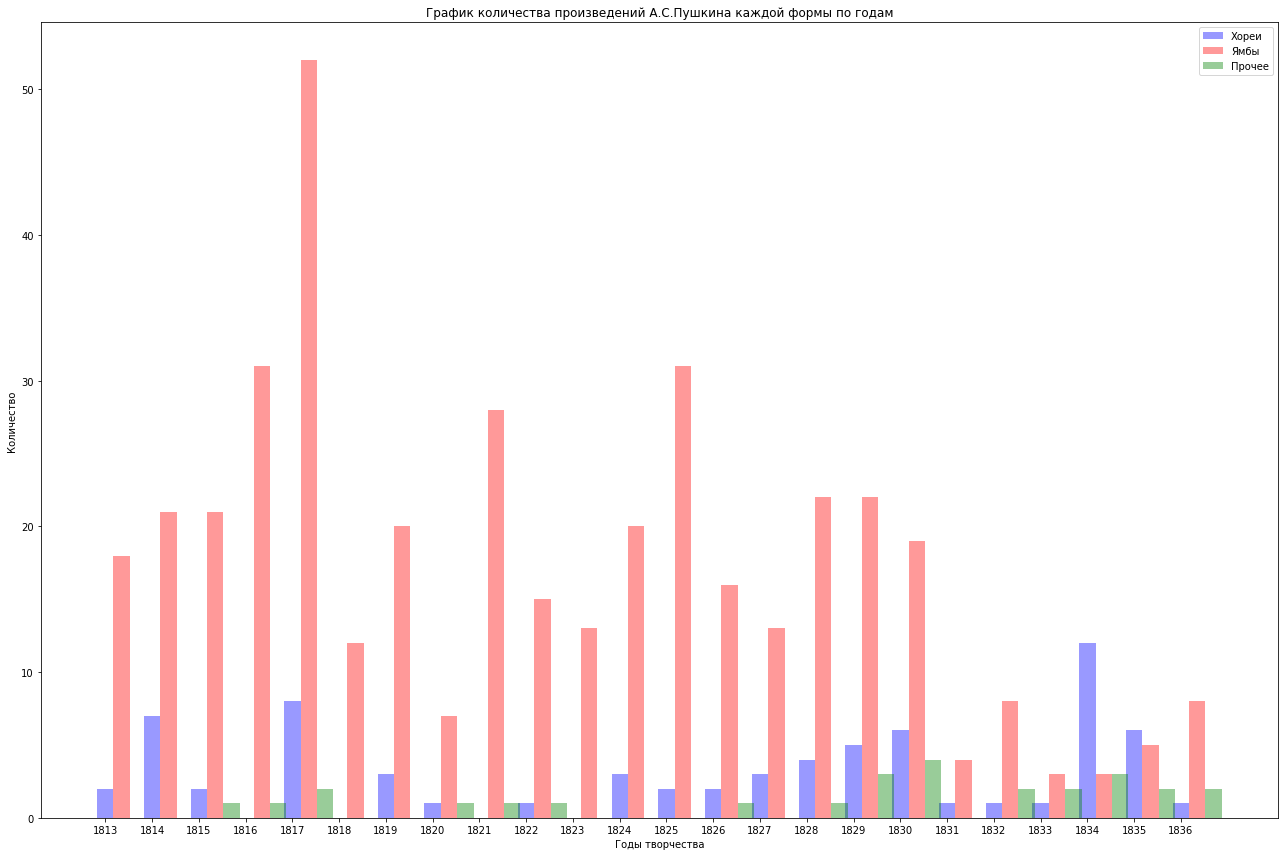

In [4]:
# Объявляем класс Year - для каждого год аактивности А.С.Пушкина будем создавать этот класс с соответствующим атрибутом
# year, и сохранять в него количество стихотворений каждой формы.
class Year:
    def __init__(self, year, horejs=0, yambs=0, others=0):
        self.year = year
        self.horejs = horejs
        self.yambs = yambs
        self.others = others

# Получаем список всех лет активности поэта при помощи set-а, затем возвращаем к типу list.
years = list(set([i.year for i in poems]))

# В данный список будем добавлять элементы класса Year.
stats = []

# Осуществляем вышеописанную операцию.
for year in years:
    stats.append(Year(year))
    
# Теперьдля каждого года считаем количество различных форм.
for each in poems:
    if each.form == 'Хорей':
        stats[each.year-1813].horejs += 1
    if each.form == 'Ямб':
        stats[each.year-1813].yambs += 1
    if each.form == 'Прочее':
        stats[each.year-1813].others += 1

# Создаем массив, в котором на каждом шаге итерации добавляем год и число стихотворений каждой формы, после чего транспонируем
# получившийся массив, поскольку для построения графика требуется создать списки каждой формы, в котором хранится количество
# произведений данной формы по годам.
graph = np.array([(i.year, i.horejs, i.yambs, i.others) for i in stats]).transpose()
g_horejs = graph[1]
g_yambs = graph[2]
g_others = graph[3]

# Приступаем к созданию графика.
fig, ax = plt.subplots(figsize=(18, 12))

# Определяем количество элементов по оси абсцисс.
index = np.arange(len(years))

# Настраиваем ширину гистограмм.
bar_width = 0.35

# Определяем прозрачность гистограмм.
opacity = 0.4

# Переводим years в требуемый тип.
years = np.array(years)

# Чертим гистограммы для каждой формы.
draw_horejs = ax.bar(years, g_horejs, bar_width,
                alpha=opacity, color='b', label='Хореи')

draw_yambs = ax.bar(years + bar_width, g_yambs, bar_width,
                alpha=opacity, color='r', label='Ямбы')

draw_others = ax.bar(years + 2 * bar_width, g_others, bar_width,
               alpha = opacity, color='g', label='Прочее')

# Добавляем графику аккуратность и красивость :)
ax.set_xlabel('Годы творчества')
ax.set_ylabel('Количество')
ax.set_title('График количества произведений А.С.Пушкина каждой формы по годам')
ax.set_xticks(years)
ax.legend()

fig.tight_layout()

# По необходимости можем сохранить данный график на компьютер.
#plt.savefig('picture_pushkin_poems.jpg')

# Готово! Любуемся получившимся созданием.
plt.show()